In [1]:
import zipfile

import os

import pandas as pd
import numpy as np

import datetime

import re

import nltk

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') # uses Multilingual Wordnet Data from OMW with newer Wordnet versions

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/r.shahukaru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/r.shahukaru/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/r.shahukaru/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [4]:
from textblob import TextBlob # to use .correct() method to correct spellings

In [5]:
%%time

with zipfile.ZipFile('../data/txt_reviews.zip') as zip_ref:
    zip_ref.extractall('../data/')

CPU times: user 26.2 s, sys: 1min 32s, total: 1min 58s
Wall time: 4min 57s


In [6]:
files = [f'../data/txt_reviews/{x}' for x in os.listdir('../data/txt_reviews')]

In [7]:
%%time

info = []

for file in files:
    with open(file, 'r') as f:
        lines = f.readlines()
        
        info.append([each_line.split(':')[1].strip() for each_line in lines])

CPU times: user 6.27 s, sys: 30.4 s, total: 36.6 s
Wall time: 2min 25s


In [8]:
with open(files[0], 'r') as f:
    
    lines = f.readlines()
    cols = [each_line.split(':')[0] for each_line in lines]

In [9]:
df = pd.DataFrame(columns = cols)

In [10]:
df['ProductId'] = [information[0] for information in info]

df['UserId'] = [information[1] for information in info]

df['ProfileName'] = [information[2] for information in info]

df['HelpfulnessNumerator'] = [information[3] for information in info]

df['HelpfulnessDenominator'] = [information[4] for information in info]

df['Score'] = [information[5] for information in info]

df['Time'] = [information[6] for information in info]

df['ReviewSummary'] = [information[7] for information in info]

df['ReviewText'] = [information[8] for information in info]

In [11]:
df.dropna(inplace= True)
df.reset_index(inplace = True, drop= True)

In [12]:
df.shape

(568454, 9)

In [13]:
df.drop_duplicates(inplace= True)
df.shape

(568167, 9)

## Splitting into train and test

In [14]:
X = df[[x for x in df.columns if x != 'Score']]
y = df['Score']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.85, random_state = 100, stratify= y)

### Creating a function to clean X

In [16]:
def clean_X(X): 
    
    X['Review'] = X['ReviewSummary'] + " " + X['ReviewText']
    X.drop(['ProductId', 'UserId', 'ProfileName', 'Time', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'ReviewSummary', 'ReviewText'], axis = 1, inplace = True)
    
    
    return X

### Creating a function to clean y

In [17]:
def clean_y(y):
    y_clean = []
    
    for score in y:
        if score in ['1', '2']:
            y_clean.append('Negative')
        else:
            y_clean.append('Positive')
            
    return pd.Series(y_clean, name= 'score')

## Creating a function to preprocess the data

In [18]:
# initialization
stemmer = PorterStemmer()

In [19]:
# initialization
lemmatizer = WordNetLemmatizer()

In [20]:
def preprocess(text, flag):
    
    text = re.sub("n't", " not", text)
    text = re.sub("\:\(", "bad", text)
    text = re.sub("\:\)", "good", text)
    text = re.sub("not good", "bad", text)
    text = re.sub("not great", "bad", text)
    text = re.sub("not bad", "average", text)
    
    #1. Removing special characters and digits
    sentence = re.sub("[^a-zA-Z]", " ", text)
    
    #2. Converting to lowercase
    sentence_1 = sentence.lower()
    
    #3. Tokenization (Word-level)
    tokens = sentence_1.split()
    
    #3.1. TextBlob- Correcting the spellings
    tokens_correct_spell = [str(TextBlob(token)) for token in tokens]

    #4. Removing stopwords
    extra_stops = ['br', 'http', 'www', 'k']
    stop_words = [x for x in stopwords.words('english') if x not in ['not', 'but']] + extra_stops
    
    clean_tokens = [token for token in tokens_correct_spell if token not in stop_words]

    #5. stemming
    if(flag == 'stem'):
        clean_tokens_final = [stemmer.stem(word) for word in clean_tokens]
    else:
        clean_tokens_final = [lemmatizer.lemmatize(word) for word in clean_tokens]
    
    return pd.Series([" ".join(clean_tokens_final), len(clean_tokens_final)])

# 1. Train data

## 1.1.1. Cleaning X_train

In [21]:
%%time

X_train = clean_X(X_train)
X_train

CPU times: user 123 ms, sys: 31 ms, total: 154 ms
Wall time: 153 ms


,Review
380818,"Great bang for the ""caloric"" buck! At only 80 ..."
21338,"My Favorite I sent for the tea, because I can'..."
368711,New Love! I absolutely love these chocolate ba...
141202,Very fine Chamomile tea I have been drinking t...
180881,Wellness Simple Solutions Dog Food My dogs do ...
...,...
150122,"Sickening filler ingredients, high price I thi..."
295370,Bold Flavor I have tried many k-cups and this ...
118004,Nylabone Durable Dental Dinosaur My dogs had t...
303837,Pretty damn good....but I LIKE the Wawa/Conven...


## 1.1.2. Cleaning y_train

In [22]:
y_train = clean_y(y_train)
y_train

0         Positive
1         Positive
2         Positive
3         Positive
4         Positive
            ...   
482936    Negative
482937    Positive
482938    Negative
482939    Positive
482940    Positive
Name: score, Length: 482941, dtype: object

## 1.2 Preprocessing X_train

In [23]:
from tqdm import tqdm, tqdm_notebook

In [24]:
tqdm.pandas()

In [25]:
temp_df = X_train['Review'].progress_apply(lambda x: preprocess(x, 'stem'))
temp_df.columns = ['review_clean_text_stem', 'review_text_length_stem']

100%|█████████████████████████████████| 482941/482941 [04:03<00:00, 1981.61it/s]


In [26]:
X_train = temp_df
X_train

,review_clean_text_stem,review_text_length_stem
380818,great bang calor buck calori great bang calor ...,30
21338,favorit sent tea ca not buy smaller town move ...,12
368711,new love absolut love chocol bar come nice wra...,95
141202,fine chamomil tea drink chamomil tea past year...,17
180881,well simpl solut dog food dog well well simpl ...,17
...,...,...
150122,sicken filler ingredi high price think ingredi...,38
295370,bold flavor tri mani cup one far favorit deep ...,13
118004,nylabon durabl dental dinosaur dog chew apart ...,16
303837,pretti damn good but like wawa conveni store s...,47


## 1.3 Data Transformation

### 1.3.1 Bag of Words approach

#### Just considering revtext and not revsum

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# Initializing the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.
vocab = CountVectorizer()

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

X_train_bow = vocab.fit_transform(X_train['review_clean_text_stem'])

#### Unique Words

In [28]:
# We can look at unique words by using 'vocabulary_'

vocab.vocabulary_

{'great': 26398,
 'bang': 4715,
 'calor': 8951,
 'buck': 8079,
 'calori': 8953,
 'low': 35998,
 'sugar': 59322,
 'fat': 21749,
 'high': 28542,
 'protein': 48602,
 'tast': 60765,
 'like': 35118,
 'pepperoni': 45629,
 'stick': 58496,
 'without': 68317,
 'mayb': 37620,
 'littl': 35423,
 'dri': 18224,
 'side': 55426,
 'but': 8453,
 'averag': 4093,
 'use': 65425,
 'workout': 68653,
 'favorit': 21829,
 'sent': 54418,
 'tea': 60948,
 'ca': 8644,
 'not': 42059,
 'buy': 8556,
 'smaller': 56233,
 'town': 62919,
 'move': 40074,
 'glad': 25383,
 'back': 4392,
 'shelf': 54895,
 'new': 41391,
 'love': 35935,
 'absolut': 244,
 'chocol': 11241,
 'bar': 4762,
 'come': 12648,
 'nice': 41514,
 'wrap': 68790,
 'thin': 61809,
 'oz': 44370,
 'troubl': 63429,
 'set': 54582,
 'groov': 26710,
 'pattern': 45158,
 'make': 36697,
 'easi': 18775,
 'break': 7552,
 'triangl': 63245,
 'though': 61939,
 'prefer': 47861,
 'crack': 14068,
 'open': 43463,
 'eat': 18813,
 'tini': 62282,
 'piec': 46384,
 'sweet': 60040,
 '

In [29]:
print("Total unique words", len(vocab.vocabulary_))

print("Type of train features:", type(X_train_bow))

print("Shape of input data:", X_train_bow.shape)

Total unique words 70211
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data: (482941, 70211)


## 2.1.1. Cleaning X_test

In [30]:
%%time

X_test = clean_X(X_test)
X_test

CPU times: user 35.7 ms, sys: 30.5 ms, total: 66.2 ms
Wall time: 65.6 ms


,Review
529445,One of the best breakfast teas Yorkshire Gold ...
271152,Grilled is the best! My cat loves the Fancy Fe...
415447,"Wolfgang Puck Coffee, Vienna Coffee House grea..."
333254,Everything a Cola should be This is the best C...
71360,Like Something You might find for sale at a fo...
...,...
152671,Excellent Oatmeal Bar These Bars are the best ...
435958,Almond Anise Biscotti Celiac so this is a real...
170682,they just dont like em only 1 of my 2 cats hav...
391149,great snack This product is a healthy snack du...


## 2.1.2. Cleaning y_teset

In [31]:
y_test = clean_y(y_test)
y_test

0        Positive
1        Positive
2        Positive
3        Positive
4        Negative
           ...   
85221    Positive
85222    Positive
85223    Negative
85224    Positive
85225    Positive
Name: score, Length: 85226, dtype: object

## 2.2. Preprocessing X_test

In [32]:
temp_df = X_test['Review'].progress_apply(lambda x: preprocess(x, 'stem'))
temp_df.columns = ['review_clean_text_stem', 'review_text_length_stem']

100%|███████████████████████████████████| 85226/85226 [00:42<00:00, 2028.39it/s]


In [33]:
X_test = temp_df
X_test

,review_clean_text_stem,review_text_length_stem
529445,one best breakfast tea yorkshir gold one favor...,72
271152,grill best cat love fanci feast grill style fa...,44
415447,wolfgang puck coffe vienna coffe hous great ta...,22
333254,everyth cola best cola ever tast first tri dec...,108
71360,like someth might find sale four year old juic...,205
...,...,...
152671,excel oatmeal bar bar best ever not sweet grea...,22
435958,almond anis biscotti celiac real treat morn cu...,9
170682,dont like em cat shown interest mylar toy she ...,42
391149,great snack product healthi snack workday kid ...,17


## 2.3 Data Transformation

### Bag of Words

In [34]:
X_test_bow = vocab.transform(X_test['review_clean_text_stem'])

In [35]:
print("Total unique words", len(vocab.vocabulary_))

print("Type of test features:", type(X_test_bow))

Total unique words 70211
Type of test features: <class 'scipy.sparse._csr.csr_matrix'>


# 3. Model

## Random Forest

In [36]:
%%time

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train_bow, y_train)

CPU times: user 14min 15s, sys: 878 ms, total: 14min 16s
Wall time: 14min 16s


RandomForestClassifier()

In [37]:
y_test_pred = classifier.predict(X_test_bow)

In [38]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred), end = "\n")

print(classification_report(y_test, y_test_pred))

0.9335766080773473
              precision    recall  f1-score   support

    Negative       0.98      0.55      0.71     12300
    Positive       0.93      1.00      0.96     72926

    accuracy                           0.93     85226
   macro avg       0.95      0.78      0.83     85226
weighted avg       0.94      0.93      0.93     85226



In [39]:
import pickle

In [40]:
pickle.dump(vocab, open("bow.pkl", "wb"))

In [41]:
pickle.dump(classifier, open("model.pkl", "wb"))

## Logistic Regression

In [42]:
%%time

from sklearn.linear_model import LogisticRegression
classifier_logistic = LogisticRegression()
classifier_logistic.fit(X_train_bow, y_train)

CPU times: user 4.51 s, sys: 2.14 s, total: 6.65 s
Wall time: 4.34 s


/Users/r.shahukaru/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [43]:
y_test_pred_logistic = classifier_logistic.predict(X_test_bow)

In [44]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred_logistic))

print(classification_report(y_test, y_test_pred_logistic))

0.9326496609016028
              precision    recall  f1-score   support

    Negative       0.82      0.69      0.75     12300
    Positive       0.95      0.97      0.96     72926

    accuracy                           0.93     85226
   macro avg       0.88      0.83      0.85     85226
weighted avg       0.93      0.93      0.93     85226



In [45]:
pickle.dump(classifier_logistic, open("logistic_reg_model.pkl", "wb"))

---------------------------------------------------------------------------------------------------------------

In [46]:
def preprocess_str(text):   
      
    flag = 'stem'
    
    text = re.sub("n't", " not", text)
    text = re.sub("\:\(", "bad", text)
    text = re.sub("\:\)", "good", text)
    text = re.sub("not good", "bad", text)
    text = re.sub("not great", "bad", text)
    text = re.sub("not bad", "average", text)
   
    
    #1. Removing special characters and digits
    sentence = re.sub("[^a-zA-Z]", " ", text)
    
    #2. Converting to lowercase
    sentence_1 = sentence.lower()
    
    #3. Tokenization (Word-level)
    tokens = sentence_1.split()
    
    #3.1. TextBlob- Correcting the spellings
    tokens_correct_spell = [str(TextBlob(token)) for token in tokens]

    #4. Removing stopwords
    extra_stops = ['br', 'http', 'www', 'k']
    stop_words = [x for x in stopwords.words('english') if x not in ['not', 'but']] + extra_stops
    
    clean_tokens = [token for token in tokens_correct_spell if token not in stop_words]

    #5. stemming
    if(flag == 'stem'):
        clean_tokens_final = [stemmer.stem(word) for word in clean_tokens]
    else:
        clean_tokens_final = [lemmatizer.lemmatize(word) for word in clean_tokens]
    
    return pd.Series([" ".join(clean_tokens_final)])

## 04. Working Example

In [47]:
preprocess_str("Very good burger.")

0    good burger
dtype: object

In [48]:
preprocess_str("Hated the food. Wouldn't recommend it.")

0    hate food would not recommend
dtype: object

In [49]:
a = vocab.transform(preprocess_str("Very good burger."))
a

<1x70211 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [50]:
a[0]

<1x70211 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [53]:
text = str(input("Please input a review: "))

a = vocab.transform(preprocess_str(text))

print()
print(classifier.predict(a)[0])

Please input a review: Worst product I have ever used

Negative


# 05. Saving the Final Model

Note:

- We are not performing cross-validation as the runtime is exceeding the limits of the machine. 
- And based on the accuracy, precision, and F1 scores, we can clearly see that the model is already performing really well in analysing the sentiment of a text. 

## 05.1. Training the final model on the whole dataset instead of splitting

In [55]:
X = clean_X(X)
y = clean_y(y)

In [56]:
temp_df = X['Review'].progress_apply(lambda x: preprocess(x, 'stem'))
temp_df.columns = ['review_clean_text_stem', 'review_text_length_stem']

100%|█████████████████████████████████| 568167/568167 [04:47<00:00, 1977.76it/s]


In [57]:
X = temp_df

In [58]:
# Initializing the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.
vocab_final = CountVectorizer()

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

X_bow = vocab_final.fit_transform(X['review_clean_text_stem'])

In [59]:
%%time

from sklearn.ensemble import RandomForestClassifier
classifier_final = RandomForestClassifier()
classifier_final.fit(X_bow, y)

CPU times: user 19min 16s, sys: 1.09 s, total: 19min 17s
Wall time: 19min 18s


RandomForestClassifier()

## 05.2. Pickling

In [60]:
import pickle

In [61]:
pickle.dump(vocab_final, open("bow.pkl", "wb"))

In [62]:
pickle.dump(classifier_final, open("model.pkl", "wb"))

In [63]:
pickle.dump(preprocess_str, open("preprocess_str.pkl", "wb"))

## 06. Word Cloud

In [90]:
X = df[[x for x in df.columns if x != 'Score']]
y = df['Score']

In [91]:
df_lemma = pd.concat([X["ReviewText"].progress_apply(lambda x: preprocess(x, 'lemm')), y], axis=1)

100%|█████████████████████████████████| 568167/568167 [02:39<00:00, 3551.08it/s]


In [92]:
df_lemma.columns = ["clean_text_lemma", "clean_text_lemma_length", "Score"]

In [93]:
del df_lemma["clean_text_lemma_length"]

In [94]:
df_lemma["Score"] = clean_y(df_lemma["Score"])

## Negative

In [95]:
negative = df_lemma.loc[df_lemma["Score"] == "Negative" , :]

words = ' '.join(negative.iloc[:, 0])

In [96]:
# pip install wordcloud

In [97]:
from wordcloud import WordCloud

In [98]:
negative_wordcloud = WordCloud(stopwords=stopwords.words("english"),
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(words)

In [99]:
import matplotlib.pyplot as plt

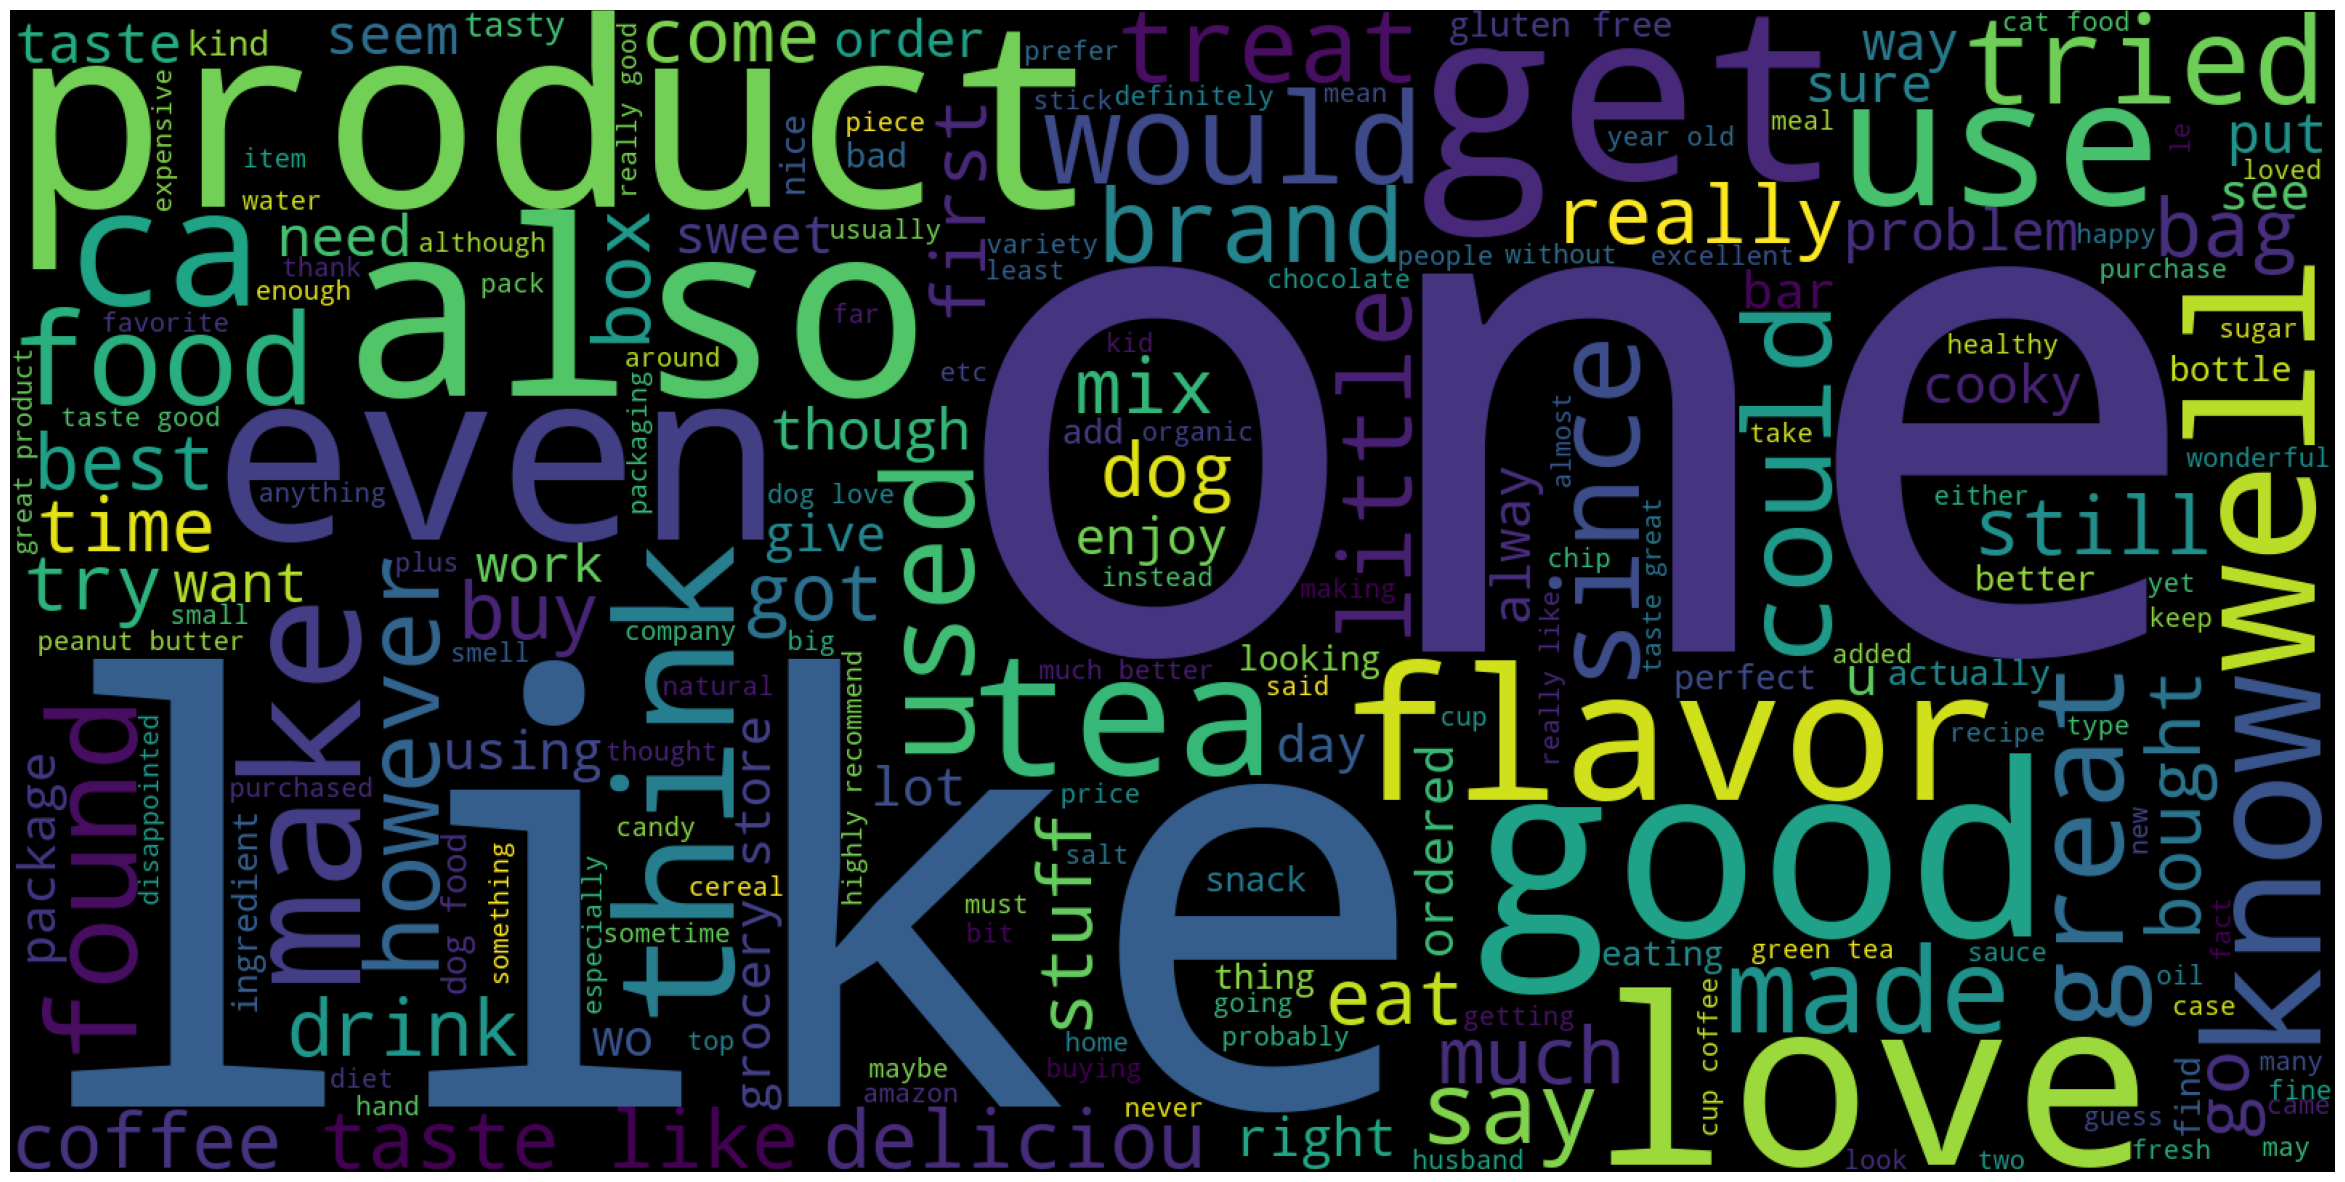

In [100]:
plt.figure(1,figsize=(30,20))
plt.imshow(negative_wordcloud)
plt.axis('off')
plt.show()

## Positive

In [101]:
positive = df_lemma.loc[df_lemma["Score"] == "Positive" , :]

words = ' '.join(positive.iloc[:, 0])

In [102]:
positive_wordcloud = WordCloud(stopwords=stopwords.words("english"),
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(words)

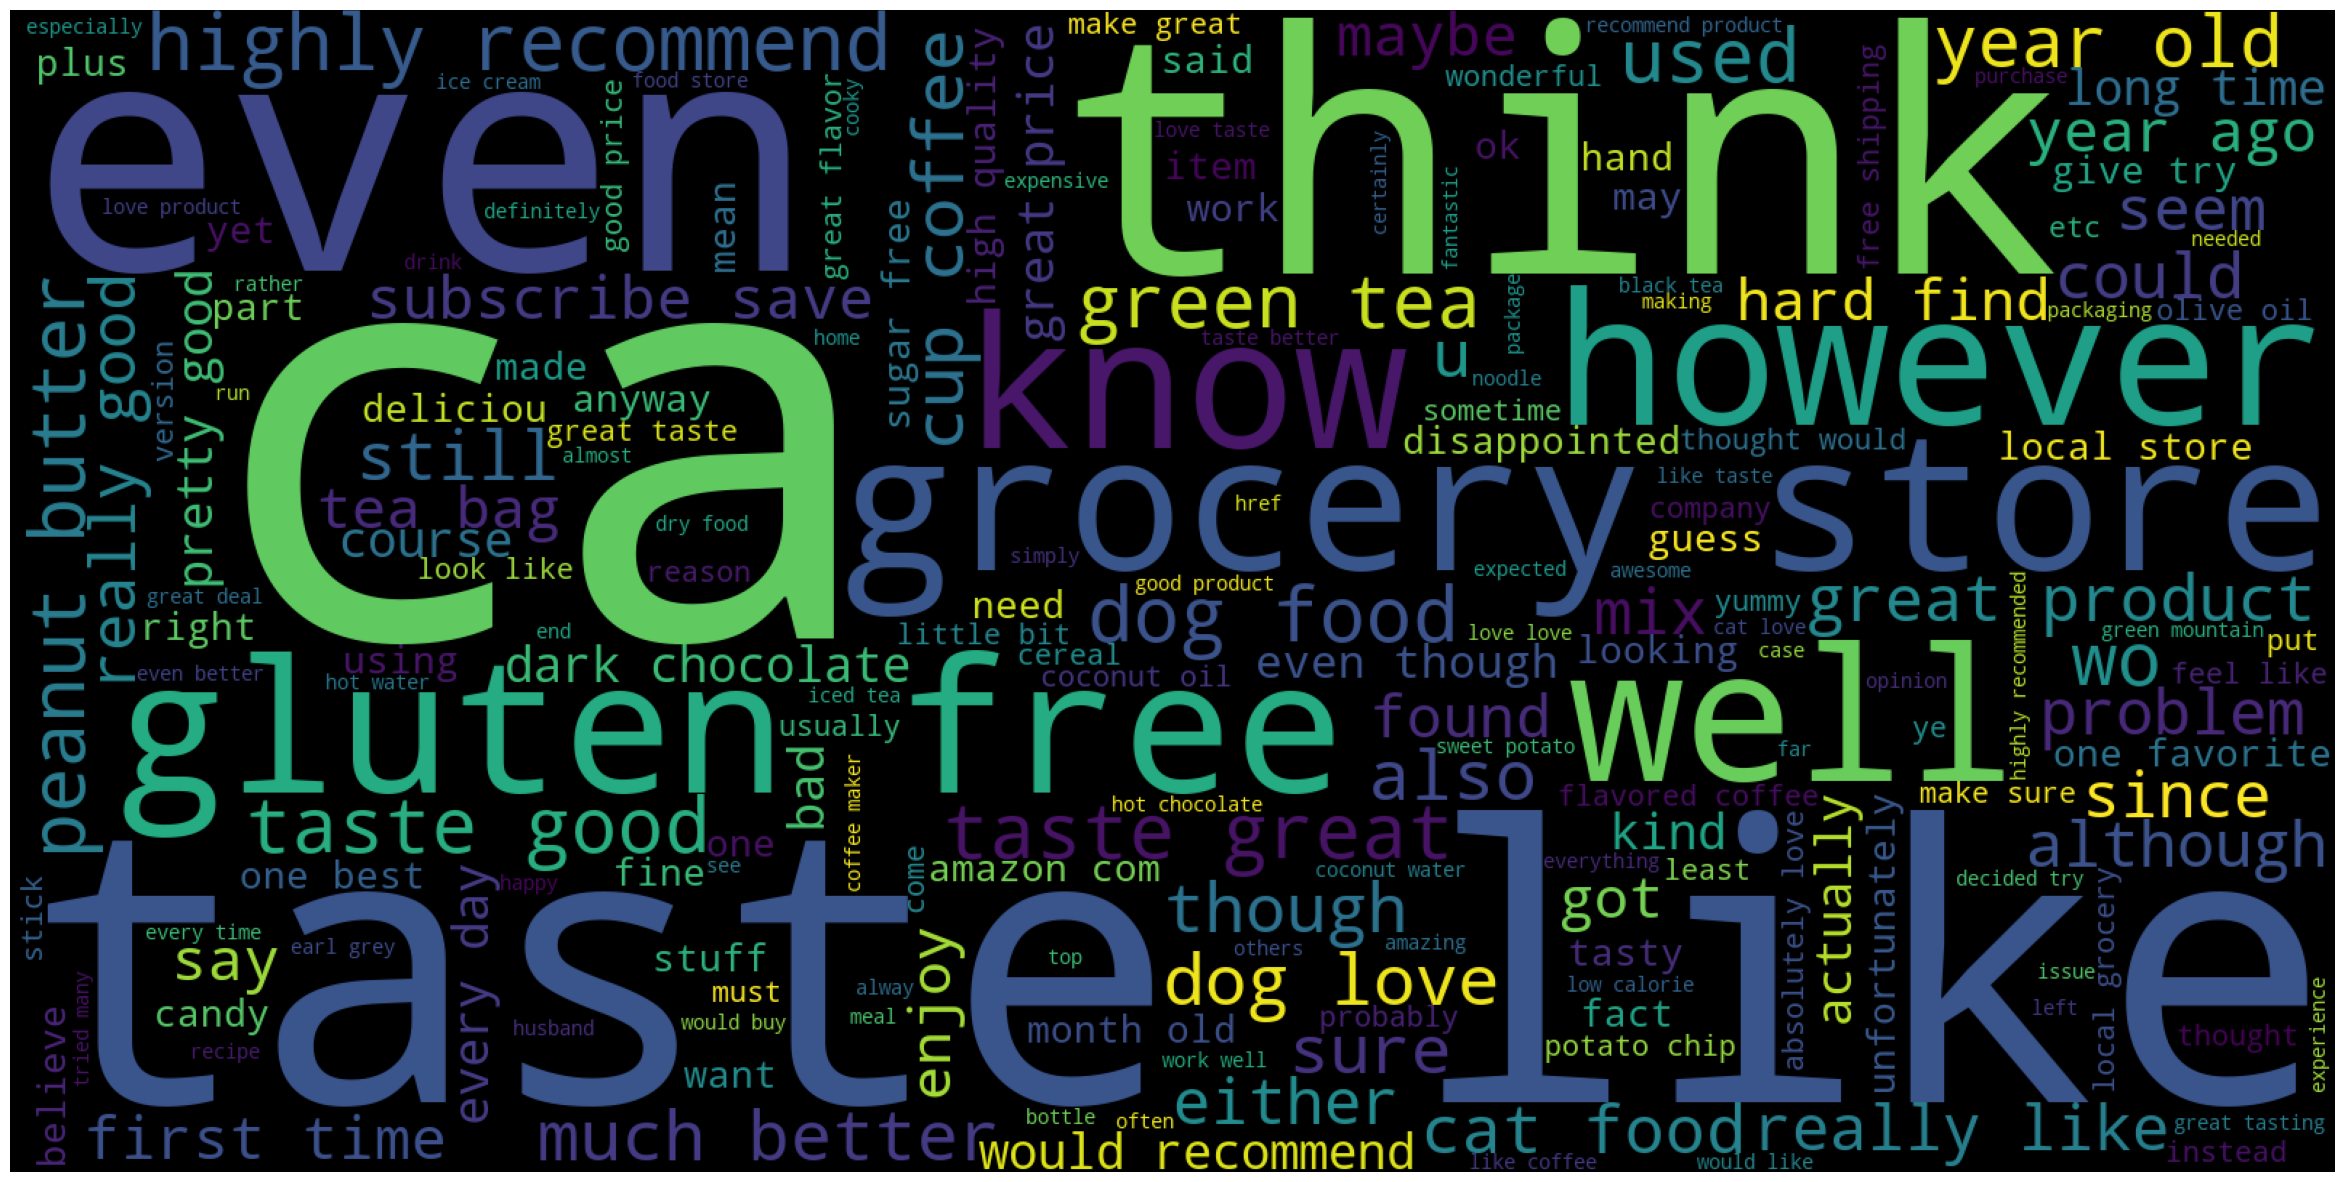

In [105]:
plt.figure(1,figsize=(30,20))
plt.imshow(positive_wordcloud)
plt.axis('off')
plt.show()

# The END